In [1]:
# pip install snntorch

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# 对LIF神经元进行简化
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

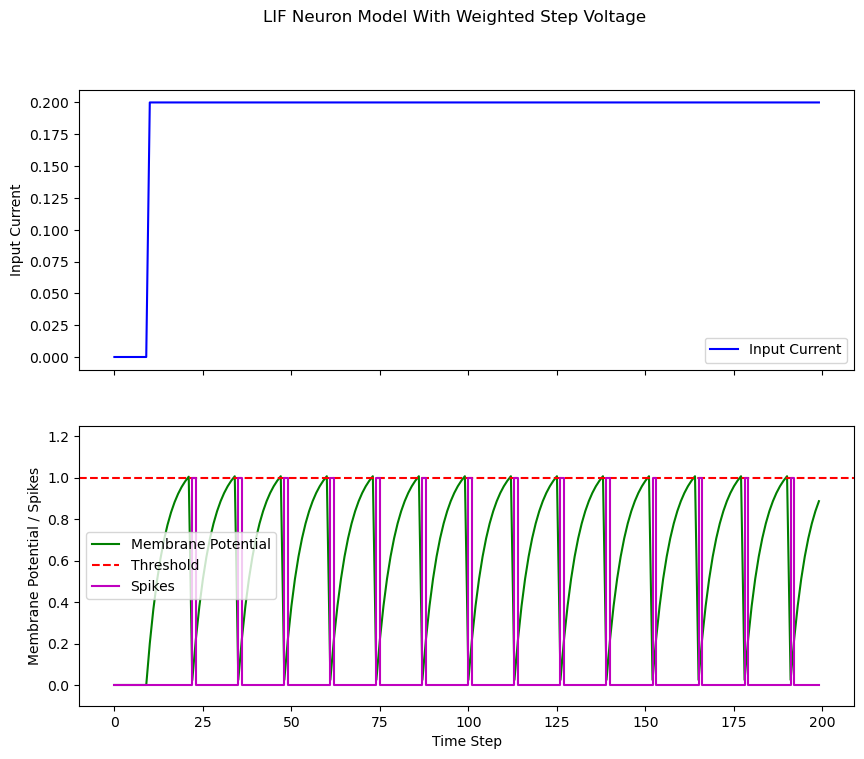

In [6]:
def plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line, ylim_max1, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax1.plot(cur_in, label='Input Current', color='b')
    ax1.set_ylabel('Input Current')
    ax1.legend()

    ax2.plot(mem_rec, label='Membrane Potential', color='g')
    ax2.axhline(y=thr_line, color='r', linestyle='--', label='Threshold')
    ax2.step(range(len(spk_rec)), spk_rec, label='Spikes', color='m', where='post')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Membrane Potential / Spikes')
    ax2.legend()

    plt.suptitle(title)
    plt.ylim(-0.1, ylim_max1)  # Adjust ylim_max1 as needed
    plt.show()



num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=1.25,
                 title="LIF Neuron Model With Weighted Step Voltage")

In [7]:
# 前面考虑的是对LIF模型的简化,现在对其进行扩充至784-1000-10的三层全连接神经网络
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

In [14]:
# 创建一个输入尖峰序列以传递到网络。有 200 个时间步长来模拟 784 个输入神经元，
# 即输入最初的维度为200*784的向量


Dimensions of spk_in: torch.Size([200, 1, 784])


Dimensions of spk_in: torch.Size([200, 1, 784])


ValueError: x and y can be no greater than 2D, but have shapes (200,) and torch.Size([200, 1, 784])

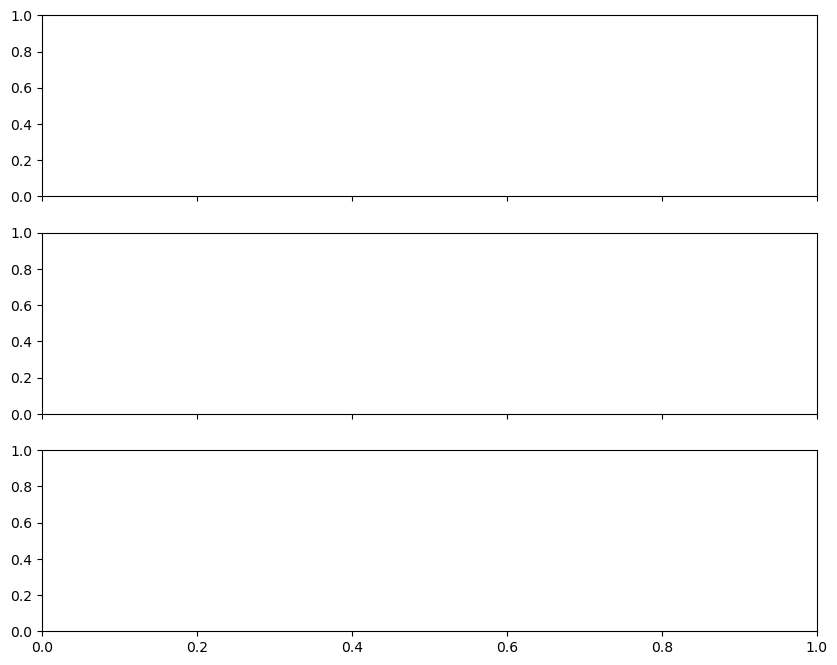

In [20]:
# network simulation

spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    ax1.plot(spk_in, label='Input Spikes', color='b', marker='o')
    ax1.set_ylabel('Input Spikes')
    ax1.legend()

    ax2.step(range(len(spk1_rec)), spk1_rec, label='Neuron 1 Spikes', color='g', where='post')
    ax2.set_ylabel('Neuron 1 Spikes')
    ax2.legend()

    ax3.step(range(len(spk2_rec)), spk2_rec, label='Neuron 2 Spikes', color='m', where='post')
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Neuron 2 Spikes')
    ax3.legend()

    plt.suptitle(title)
    plt.show()


# network simulation
mem2_rec = []
spk1_rec = []
spk2_rec = []

# Network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step])  # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1)  # mem[t+1] <-- post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    # Append membrane potentials and spikes to the lists
    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# Convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

ValueError: Length of values (1) does not match length of index (10)

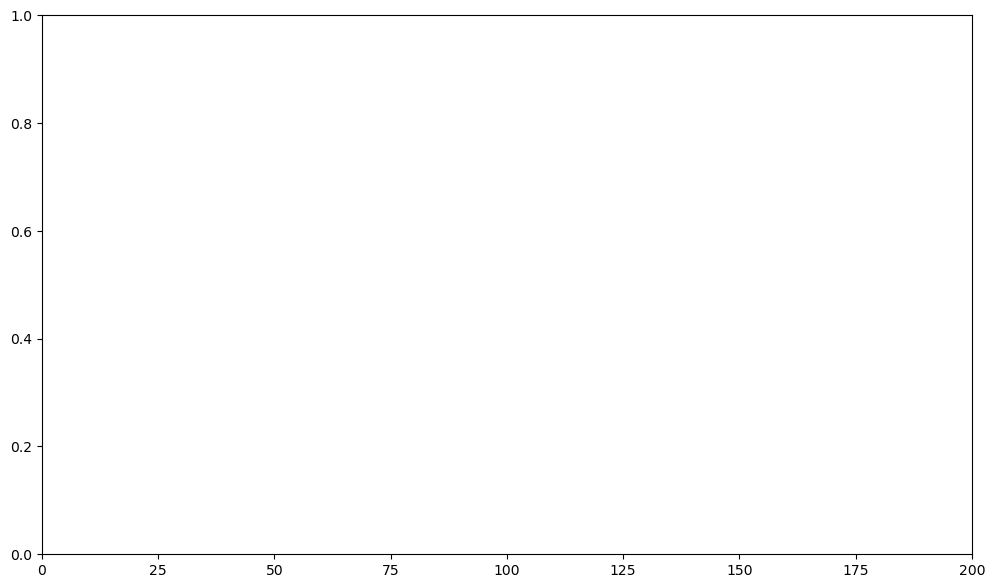

In [21]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'D:\\ffmpeg\\ffmpeg-2024-01-14-git-34a47b97de-essentials_build\\binffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")